[View in Colaboratory](https://colab.research.google.com/github/Shrey09/Machine-Learning-/blob/master/MNIST_CNN.ipynb)

In [1]:
!pip install pydrive


    100% |████████████████████████████████| 993kB 7.1MB/s 
  Running setup.py bdist_wheel for pydrive ... - done
  Stored in directory: /content/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
import numpy as np
import pandas as pd

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Activation,Dense,Dropout,Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
print("X_train Shape: ",x_train.shape)
print("Y_train Shape: ",y_train.shape)
print("X_test Shape: ",x_test.shape)
print("Y_test Shape: ",y_test.shape)

X_train Shape:  (60000, 28, 28)
Y_train Shape:  (60000,)
X_test Shape:  (10000, 28, 28)
Y_test Shape:  (10000,)


In [0]:
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
y_train = y_train.reshape(y_train.shape[0],1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
y_test = y_test.reshape(y_test.shape[0],1)
input_shape = (img_rows, img_cols, 1)

In [8]:
print("X_train Shape: ",x_train.shape)
print("Y_train Shape: ",y_train.shape)
print("X_test Shape: ",x_test.shape)
print("Y_test Shape: ",y_test.shape)

X_train Shape:  (60000, 28, 28, 1)
Y_train Shape:  (60000, 1)
X_test Shape:  (10000, 28, 28, 1)
Y_test Shape:  (10000, 1)


In [0]:
#Normalize the data

x_train = x_train / 255.0
x_test = x_test / 255.0

**Encode label**

In [0]:
y_train = to_categorical(y_train, num_classes = 10)
y_test =  to_categorical(y_test, num_classes = 10)

In [0]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Valid', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(10, activation = "softmax"))

In [35]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
batch_normalization_19 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 32)        25632     
_________________________________________________________________
batch_normalization_20 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 12, 12, 64)        18496     
__________

In [0]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
epochs = 30
batch_size = 64

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [40]:
history = model.fit_generator(datagen.flow(x_train,y_train, 
                                           batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (x_test,y_test),
                              verbose = 2, 
                              steps_per_epoch = x_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/30
 - 48s - loss: 0.2452 - acc: 0.9237 - val_loss: 0.0432 - val_acc: 0.9872
Epoch 2/30
 - 43s - loss: 0.0796 - acc: 0.9760 - val_loss: 0.0376 - val_acc: 0.9893
Epoch 3/30
 - 41s - loss: 0.0688 - acc: 0.9798 - val_loss: 0.0260 - val_acc: 0.9921
Epoch 4/30
 - 42s - loss: 0.0551 - acc: 0.9838 - val_loss: 0.0474 - val_acc: 0.9867
Epoch 5/30
 - 41s - loss: 0.0521 - acc: 0.9843 - val_loss: 0.0234 - val_acc: 0.9935
Epoch 6/30
 - 42s - loss: 0.0491 - acc: 0.9861 - val_loss: 0.0336 - val_acc: 0.9897
Epoch 7/30
 - 43s - loss: 0.0416 - acc: 0.9877 - val_loss: 0.0384 - val_acc: 0.9881
Epoch 8/30
 - 43s - loss: 0.0409 - acc: 0.9880 - val_loss: 0.0429 - val_acc: 0.9864

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/30
 - 43s - loss: 0.0257 - acc: 0.9925 - val_loss: 0.0205 - val_acc: 0.9943
Epoch 10/30
 - 43s - loss: 0.0266 - acc: 0.9922 - val_loss: 0.0130 - val_acc: 0.9962
Epoch 11/30
 - 42s - loss: 0.0262 - acc: 0.9922 - val_loss: 0.0219 - val_acc: 

In [41]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.010696237237771128
Test accuracy: 0.9967


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


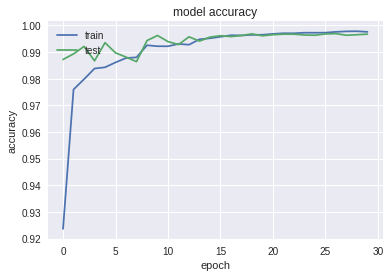

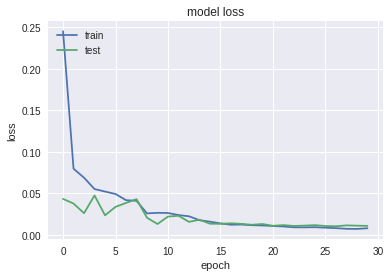

In [42]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

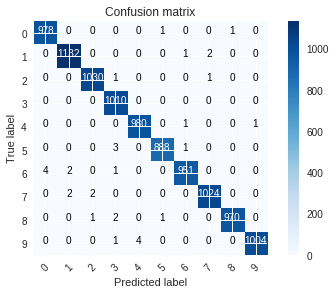

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

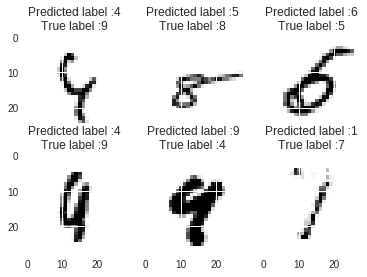

In [44]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)